In [1]:
import numpy as np
from importlib import reload
import pandas as pd
import fdc
import tqdm
fdc=reload(fdc)
import matplotlib.pyplot as plt

# REAL DATA

In [2]:
# load the data
sleep_tag = pd.read_csv('../Data_for_analysis/EPCTL06.csv')



In [3]:
sleep_data = np.load('../Data_for_analysis/EPCTL06-prep-001.npy')

In [4]:
sleep_tag['L'].unique()

array(['L', 'W', 'N1', 'N2', 'N3', 'R'], dtype=object)

Primo sample non-'L' è al sample 76800
Questo corrisponde a 600.0 secondi = 10.0 minuti


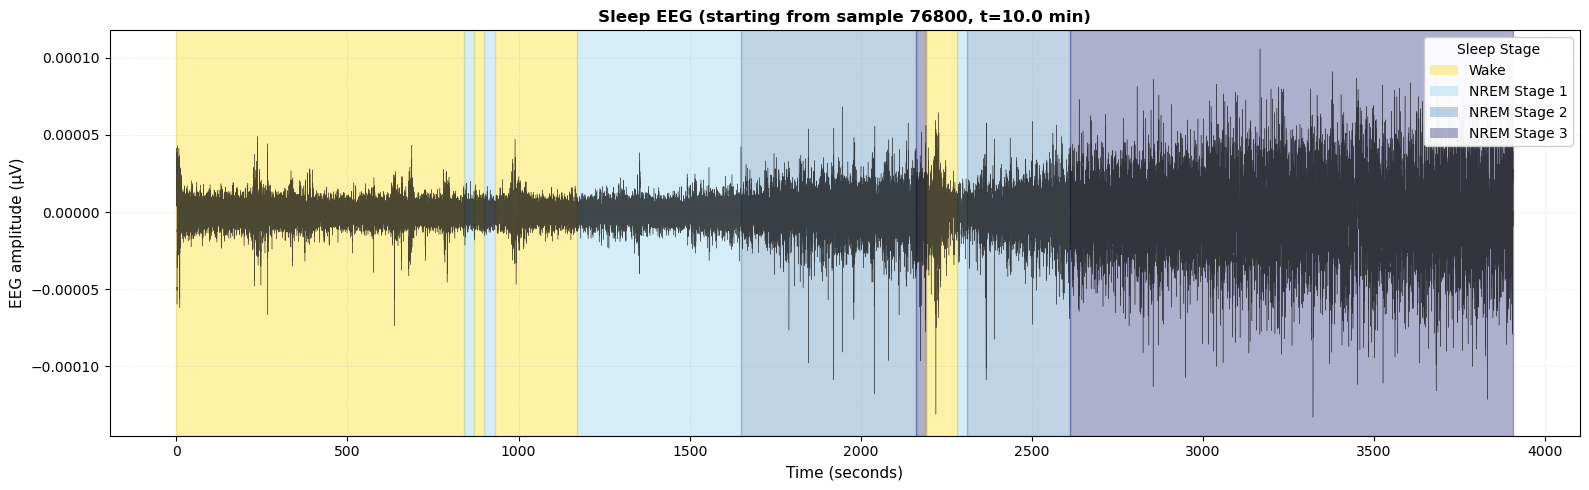


=== STATISTICHE COMPLETE ===
Total recording: 459.0 minutes

Stage distribution (tutta la registrazione):
  Wake                :   73.5 min ( 16.0%)
  NREM Stage 1        :   38.5 min (  8.4%)
  NREM Stage 2        :  187.0 min ( 40.7%)
  NREM Stage 3        :   77.0 min ( 16.8%)
  REM                 :   67.0 min ( 14.6%)
  Latency/Unknown     :   16.0 min (  3.5%)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Parametri
fs = 128
samples_per_epoch = fs * 30  # 3840

# Espandi labels
stages = sleep_tag['L'].values
expanded_labels = np.repeat(stages, samples_per_epoch)
n_samples = min(len(expanded_labels), sleep_data.shape[1])
expanded_labels = expanded_labels[:n_samples]

# TROVA DOVE FINISCONO LE 'L' INIZIALI
first_non_L = np.where(expanded_labels != 'L')[0]
if len(first_non_L) > 0:
    start_idx = first_non_L[0]
    print(f"Primo sample non-'L' è al sample {start_idx}")
    print(f"Questo corrisponde a {start_idx/fs:.1f} secondi = {start_idx/fs/60:.1f} minuti")
else:
    start_idx = 0

# PLOT A PARTIRE DAL PRIMO SAMPLE VERO
n_plot = min(500000, n_samples - start_idx)
plot_start = start_idx
plot_end = start_idx + n_plot

time_seconds = np.arange(n_plot) / fs

fig, ax = plt.subplots(figsize=(16, 5))

# Plot serie temporale
ax.plot(time_seconds, sleep_data[0, plot_start:plot_end], 
        'k-', linewidth=0.3, alpha=0.7)

# Colori per sleep stages
stage_colors = {
    'W': '#FFD700',    # Wake - giallo
    'N1': '#87CEEB',   # N1 - azzurro
    'N2': '#4682B4',   # N2 - blu
    'N3': '#191970',   # N3 - blu scuro
    'R': '#FF6347',    # REM - rosso
    'L': '#D3D3D3',    # Latency - grigio
}

# Background colorato
current_stage = expanded_labels[plot_start]
segment_start = 0

for i in range(1, n_plot + 1):
    idx = plot_start + i
    if idx >= plot_end or expanded_labels[idx] != current_stage:
        color = stage_colors.get(current_stage, '#CCCCCC')
        ax.axvspan(segment_start, (i-1)/fs, alpha=0.35, color=color)
        
        if idx < plot_end:
            current_stage = expanded_labels[idx]
            segment_start = i/fs

# Legenda
stage_order = ['W', 'N1', 'N2', 'N3', 'R', 'L']
stage_names = {
    'W': 'Wake',
    'N1': 'NREM Stage 1',
    'N2': 'NREM Stage 2', 
    'N3': 'NREM Stage 3',
    'R': 'REM',
    'L': 'Latency/Unknown'
}

unique_stages = [s for s in stage_order 
                 if s in np.unique(expanded_labels[plot_start:plot_end])]
legend_elements = [
    Patch(facecolor=stage_colors[stage], 
          label=stage_names[stage], 
          alpha=0.35)
    for stage in unique_stages
]
ax.legend(handles=legend_elements, title='Sleep Stage', 
         loc='upper right', framealpha=0.95, fontsize=10)

ax.set_xlabel('Time (seconds)', fontsize=11)
ax.set_ylabel('EEG amplitude (μV)', fontsize=11)
ax.set_title(f'Sleep EEG (starting from sample {start_idx}, t={start_idx/fs/60:.1f} min)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Statistiche complete
print(f"\n=== STATISTICHE COMPLETE ===")
print(f"Total recording: {n_samples/fs/60:.1f} minutes")
print(f"\nStage distribution (tutta la registrazione):")
for stage in stage_order:
    count = np.sum(expanded_labels == stage)
    percentage = count / len(expanded_labels) * 100
    minutes = count / fs / 60
    if count > 0:
        print(f"  {stage_names[stage]:20s}: {minutes:6.1f} min ({percentage:5.1f}%)")

In [6]:
def extract_sleep_stage_segment(sleep_data, sleep_tag, stage_label, segment_number=0, 
                               segment_length=-1, skip_first_epoch=False, fs=128):
    """
    Extract time series corresponding to a specific sleep stage occurrence.
    
    Parameters
    ----------
    sleep_data : np.ndarray, shape (n_channels, n_samples)
        Multi-channel sleep time series data
    sleep_tag : pd.DataFrame
        DataFrame with column 'L' containing sleep stage labels
    stage_label : str
        Sleep stage to extract ('W', 'N1', 'N2', 'N3', 'R', 'L')
    segment_number : int, default=0
        Which occurrence of the stage to extract (0 = first, 1 = second, etc.)
    segment_length : int, default=-1
        Length of the segment to extract in epochs (30 seconds each). 
        If -1, extract the entire segment.
        If positive, extract only the specified number of epochs.
    skip_first_epoch : bool, default=False
        If True, skip the first epoch and start from the second.
        Useful to avoid transition artifacts at stage boundaries.
        If segment_length is specified, extracts epochs 2 to (segment_length+1).
        If not enough epochs are available, falls back to including the first epoch.
    fs : int, default=128
        Sampling frequency in Hz
        
    Returns
    -------
    segment_data : np.ndarray or None
        Time series of the requested segment, shape (n_channels, n_samples_segment)
        Returns None if segment not found
    start_idx : int or None
        Starting sample index of the segment
    end_idx : int or None
        Ending sample index of the segment (exclusive)
    info : dict
        Dictionary with segment information (duration, etc.)
        
    Examples
    --------
    >>> # Extract first N1 segment (complete)
    >>> n1_data, start, end, info = extract_sleep_stage_segment(sleep_data, sleep_tag, 'N1', segment_number=0)
    
    >>> # Extract first 5 epochs (2.5 minutes) of third N2 segment
    >>> n2_data, start, end, info = extract_sleep_stage_segment(sleep_data, sleep_tag, 'N2', segment_number=2, segment_length=5)
    
    >>> # Extract 3 epochs from first N1 segment, skipping first epoch (extracts epochs 2, 3, 4)
    >>> n1_data, start, end, info = extract_sleep_stage_segment(sleep_data, sleep_tag, 'N1', segment_number=0, 
    ...                                                          segment_length=3, skip_first_epoch=True)
    """
    
    # Time parameters
    samples_per_epoch = fs * 30  # 3840 samples per 30-second epoch
    N = sleep_data.shape[0]
    
    # Expand labels to match time series resolution
    stages = sleep_tag['L'].values
    expanded_labels = np.repeat(stages, samples_per_epoch)
    n_samples = min(len(expanded_labels), sleep_data.shape[1])
    expanded_labels = expanded_labels[:n_samples]
    
    # Find all indices with the requested stage
    stage_indices = np.where(expanded_labels == stage_label)[0]
    
    if len(stage_indices) == 0:
        print(f"No samples found for stage '{stage_label}'!")
        return None, None, None, None
    
    # Find consecutive segments
    # A new segment starts when the difference between consecutive indices > 1
    breaks = np.where(np.diff(stage_indices) > 1)[0] + 1
    
    # Split indices into segments
    if len(breaks) > 0:
        segments = np.split(stage_indices, breaks)
    else:
        segments = [stage_indices]
    
    # Check if requested segment exists
    n_segments = len(segments)
    if segment_number >= n_segments:
        print(f"Segment {segment_number} not found! Stage '{stage_label}' has only {n_segments} segment(s).")
        print(f"Valid segment_number values: 0 to {n_segments - 1}")
        return None, None, None, None
    
    # Extract the requested segment
    segment_indices = segments[segment_number]
    segment_start_idx = segment_indices[0]
    segment_end_idx = segment_indices[-1] + 1  # Full segment end
    
    # Calculate available epochs in this segment
    full_n_samples = segment_end_idx - segment_start_idx
    full_n_epochs = full_n_samples // samples_per_epoch
    
    # Determine extraction parameters based on skip_first_epoch and segment_length
    first_epoch_actually_skipped = False
    
    if skip_first_epoch:
        # Check if we can actually skip the first epoch
        if segment_length > 0:
            # Need segment_length + 1 epochs total to skip first and extract segment_length
            epochs_needed = segment_length + 1
            can_skip = full_n_epochs >= epochs_needed
        else:
            # Need at least 2 epochs to skip first
            can_skip = full_n_epochs >= 2
        
        if can_skip:
            # Can skip first epoch as requested
            start_idx = segment_start_idx + samples_per_epoch
            first_epoch_actually_skipped = True
            
            if segment_length > 0:
                end_idx = start_idx + (segment_length * samples_per_epoch)
                n_epochs_extracted = segment_length
                epochs_range = f"epochs 2-{segment_length + 1}"
            else:
                # Extract all remaining epochs after skipping first
                end_idx = segment_end_idx
                n_epochs_extracted = full_n_epochs - 1
                epochs_range = f"epochs 2-{full_n_epochs}"
        else:
            # FALLBACK: Not enough epochs to skip, include first epoch
            print(f"  Warning: Requested skip_first_epoch=True, but segment has only {full_n_epochs} epoch(s).")
            print(f"           Falling back to including first epoch.")
            
            start_idx = segment_start_idx
            
            if segment_length > 0:
                if segment_length > full_n_epochs:
                    # Extract all available
                    end_idx = segment_end_idx
                    n_epochs_extracted = full_n_epochs
                else:
                    end_idx = start_idx + (segment_length * samples_per_epoch)
                    n_epochs_extracted = segment_length
                epochs_range = f"epochs 1-{n_epochs_extracted}"
            else:
                # Extract entire segment
                end_idx = segment_end_idx
                n_epochs_extracted = full_n_epochs
                epochs_range = f"epochs 1-{full_n_epochs}"
    
    else:
        # Start from first epoch (no skip)
        start_idx = segment_start_idx
        
        if segment_length > 0:
            if segment_length > full_n_epochs:
                print(f"  Warning: Requested {segment_length} epochs, but segment only has {full_n_epochs} epochs.")
                print(f"           Extracting all {full_n_epochs} available epochs.")
                end_idx = segment_end_idx
                n_epochs_extracted = full_n_epochs
            else:
                end_idx = start_idx + (segment_length * samples_per_epoch)
                n_epochs_extracted = segment_length
            epochs_range = f"epochs 1-{n_epochs_extracted}"
        else:
            # Extract entire segment
            end_idx = segment_end_idx
            n_epochs_extracted = full_n_epochs
            epochs_range = f"epochs 1-{full_n_epochs}"
    
    # Extract the data
    segment_data = sleep_data[:, start_idx:end_idx]
    
    # Calculate segment information
    n_samples_segment = end_idx - start_idx
    duration_seconds = n_samples_segment / fs
    duration_minutes = duration_seconds / 60
    
    info = {
        'stage': stage_label,
        'segment_number': segment_number,
        'total_segments': n_segments,
        'start_idx': start_idx,
        'end_idx': end_idx,
        'n_samples': n_samples_segment,
        'n_epochs': n_epochs_extracted,
        'full_segment_epochs': full_n_epochs,
        'duration_seconds': duration_seconds,
        'duration_minutes': duration_minutes,
        'n_channels': N,
        'sampling_frequency': fs,
        'truncated': segment_length > 0 and segment_length < full_n_epochs,
        'first_epoch_skipped': first_epoch_actually_skipped,
        'skip_requested': skip_first_epoch,
        'epochs_range': epochs_range
    }
    
    # Print information
    print(f"Stage '{stage_label}' - Segment {segment_number + 1}/{n_segments}:")
    print(f"  Full segment epochs: {full_n_epochs}")
    print(f"  Extracted: {epochs_range} ({n_epochs_extracted} epochs)")
    if skip_first_epoch:
        if first_epoch_actually_skipped:
            print(f"  First epoch skipped: Yes ✓")
        else:
            print(f"  First epoch skipped: No (fallback - not enough epochs)")
    print(f"  Start index: {start_idx}")
    print(f"  End index: {end_idx}")
    print(f"  Number of samples: {n_samples_segment}")
    print(f"  Duration: {duration_seconds:.2f} seconds = {duration_minutes:.2f} minutes")
    print(f"  Shape of extracted time series: {segment_data.shape}")
    
    return segment_data, start_idx, end_idx, info

In [7]:

# Helper function to list all available segments
def list_sleep_stage_segments(sleep_data, sleep_tag, stage_label, fs=128):
    """
    List all consecutive segments of a given sleep stage.
    
    Parameters
    ----------
    sleep_data : np.ndarray
        Sleep time series data
    sleep_tag : pd.DataFrame
        Sleep stage labels
    stage_label : str
        Sleep stage to analyze
    fs : int, default=128
        Sampling frequency
        
    Returns
    -------
    segments_info : list of dict
        List of dictionaries containing info about each segment
    """
    
    samples_per_epoch = fs * 30
    stages = sleep_tag['L'].values
    expanded_labels = np.repeat(stages, samples_per_epoch)
    n_samples = min(len(expanded_labels), sleep_data.shape[1])
    expanded_labels = expanded_labels[:n_samples]
    
    stage_indices = np.where(expanded_labels == stage_label)[0]
    
    if len(stage_indices) == 0:
        print(f"No samples found for stage '{stage_label}'!")
        return []
    
    breaks = np.where(np.diff(stage_indices) > 1)[0] + 1
    segments = np.split(stage_indices, breaks) if len(breaks) > 0 else [stage_indices]
    
    segments_info = []
    print(f"\nStage '{stage_label}' has {len(segments)} consecutive segment(s):\n")
    
    for i, seg_indices in enumerate(segments):
        start_idx = seg_indices[0]
        end_idx = seg_indices[-1] + 1
        n_samples_seg = end_idx - start_idx
        duration_sec = n_samples_seg / fs
        duration_min = duration_sec / 60
        
        info = {
            'segment_number': i,
            'start_idx': start_idx,
            'end_idx': end_idx,
            'n_samples': n_samples_seg,
            'duration_seconds': duration_sec,
            'duration_minutes': duration_min,
            'start_time_minutes': start_idx / fs / 60
        }
        
        segments_info.append(info)
        
        print(f"  Segment {i}:")
        print(f"    Time: {info['start_time_minutes']:.2f} - {(end_idx/fs/60):.2f} minutes")
        print(f"    Indices: {start_idx} - {end_idx}")
        print(f"    Duration: {duration_sec:.2f} s ({duration_min:.2f} min)")
        print(f"    Samples: {n_samples_seg}\n")
    
    return segments_info

In [23]:
list_sleep_stage_segments(sleep_data, sleep_tag, stage_label='L', fs=128)


Stage 'L' has 2 consecutive segment(s):

  Segment 0:
    Time: 0.00 - 10.00 minutes
    Indices: 0 - 76800
    Duration: 600.00 s (10.00 min)
    Samples: 76800

  Segment 1:
    Time: 453.00 - 459.00 minutes
    Indices: 3479040 - 3525120
    Duration: 360.00 s (6.00 min)
    Samples: 46080



[{'segment_number': 0,
  'start_idx': 0,
  'end_idx': 76800,
  'n_samples': 76800,
  'duration_seconds': 600.0,
  'duration_minutes': 10.0,
  'start_time_minutes': 0.0},
 {'segment_number': 1,
  'start_idx': 3479040,
  'end_idx': 3525120,
  'n_samples': 46080,
  'duration_seconds': 360.0,
  'duration_minutes': 6.0,
  'start_time_minutes': 453.0}]

In [24]:
list_sleep_stage_segments(sleep_data, sleep_tag, stage_label='W', fs=128)


Stage 'W' has 22 consecutive segment(s):

  Segment 0:
    Time: 10.00 - 24.00 minutes
    Indices: 76800 - 184320
    Duration: 840.00 s (14.00 min)
    Samples: 107520

  Segment 1:
    Time: 24.50 - 25.00 minutes
    Indices: 188160 - 192000
    Duration: 30.00 s (0.50 min)
    Samples: 3840

  Segment 2:
    Time: 25.50 - 29.50 minutes
    Indices: 195840 - 226560
    Duration: 240.00 s (4.00 min)
    Samples: 30720

  Segment 3:
    Time: 46.50 - 48.00 minutes
    Indices: 357120 - 368640
    Duration: 90.00 s (1.50 min)
    Samples: 11520

  Segment 4:
    Time: 80.00 - 82.00 minutes
    Indices: 614400 - 629760
    Duration: 120.00 s (2.00 min)
    Samples: 15360

  Segment 5:
    Time: 88.00 - 89.00 minutes
    Indices: 675840 - 683520
    Duration: 60.00 s (1.00 min)
    Samples: 7680

  Segment 6:
    Time: 103.50 - 106.00 minutes
    Indices: 794880 - 814080
    Duration: 150.00 s (2.50 min)
    Samples: 19200

  Segment 7:
    Time: 143.00 - 144.00 minutes
    Indices: 109

[{'segment_number': 0,
  'start_idx': 76800,
  'end_idx': 184320,
  'n_samples': 107520,
  'duration_seconds': 840.0,
  'duration_minutes': 14.0,
  'start_time_minutes': 10.0},
 {'segment_number': 1,
  'start_idx': 188160,
  'end_idx': 192000,
  'n_samples': 3840,
  'duration_seconds': 30.0,
  'duration_minutes': 0.5,
  'start_time_minutes': 24.5},
 {'segment_number': 2,
  'start_idx': 195840,
  'end_idx': 226560,
  'n_samples': 30720,
  'duration_seconds': 240.0,
  'duration_minutes': 4.0,
  'start_time_minutes': 25.5},
 {'segment_number': 3,
  'start_idx': 357120,
  'end_idx': 368640,
  'n_samples': 11520,
  'duration_seconds': 90.0,
  'duration_minutes': 1.5,
  'start_time_minutes': 46.5},
 {'segment_number': 4,
  'start_idx': 614400,
  'end_idx': 629760,
  'n_samples': 15360,
  'duration_seconds': 120.0,
  'duration_minutes': 2.0,
  'start_time_minutes': 80.0},
 {'segment_number': 5,
  'start_idx': 675840,
  'end_idx': 683520,
  'n_samples': 7680,
  'duration_seconds': 60.0,
  'dur

In [25]:
list_sleep_stage_segments(sleep_data, sleep_tag, stage_label='N1', fs=128)


Stage 'N1' has 27 consecutive segment(s):

  Segment 0:
    Time: 24.00 - 24.50 minutes
    Indices: 184320 - 188160
    Duration: 30.00 s (0.50 min)
    Samples: 3840

  Segment 1:
    Time: 25.00 - 25.50 minutes
    Indices: 192000 - 195840
    Duration: 30.00 s (0.50 min)
    Samples: 3840

  Segment 2:
    Time: 29.50 - 37.50 minutes
    Indices: 226560 - 288000
    Duration: 480.00 s (8.00 min)
    Samples: 61440

  Segment 3:
    Time: 48.00 - 48.50 minutes
    Indices: 368640 - 372480
    Duration: 30.00 s (0.50 min)
    Samples: 3840

  Segment 4:
    Time: 82.00 - 83.00 minutes
    Indices: 629760 - 637440
    Duration: 60.00 s (1.00 min)
    Samples: 7680

  Segment 5:
    Time: 89.00 - 89.50 minutes
    Indices: 683520 - 687360
    Duration: 30.00 s (0.50 min)
    Samples: 3840

  Segment 6:
    Time: 106.00 - 107.00 minutes
    Indices: 814080 - 821760
    Duration: 60.00 s (1.00 min)
    Samples: 7680

  Segment 7:
    Time: 154.00 - 154.50 minutes
    Indices: 1182720 - 

[{'segment_number': 0,
  'start_idx': 184320,
  'end_idx': 188160,
  'n_samples': 3840,
  'duration_seconds': 30.0,
  'duration_minutes': 0.5,
  'start_time_minutes': 24.0},
 {'segment_number': 1,
  'start_idx': 192000,
  'end_idx': 195840,
  'n_samples': 3840,
  'duration_seconds': 30.0,
  'duration_minutes': 0.5,
  'start_time_minutes': 25.0},
 {'segment_number': 2,
  'start_idx': 226560,
  'end_idx': 288000,
  'n_samples': 61440,
  'duration_seconds': 480.0,
  'duration_minutes': 8.0,
  'start_time_minutes': 29.5},
 {'segment_number': 3,
  'start_idx': 368640,
  'end_idx': 372480,
  'n_samples': 3840,
  'duration_seconds': 30.0,
  'duration_minutes': 0.5,
  'start_time_minutes': 48.0},
 {'segment_number': 4,
  'start_idx': 629760,
  'end_idx': 637440,
  'n_samples': 7680,
  'duration_seconds': 60.0,
  'duration_minutes': 1.0,
  'start_time_minutes': 82.0},
 {'segment_number': 5,
  'start_idx': 683520,
  'end_idx': 687360,
  'n_samples': 3840,
  'duration_seconds': 30.0,
  'duration_

In [26]:
list_sleep_stage_segments(sleep_data, sleep_tag, stage_label='N2', fs=128)


Stage 'N2' has 32 consecutive segment(s):

  Segment 0:
    Time: 37.50 - 46.00 minutes
    Indices: 288000 - 353280
    Duration: 510.00 s (8.50 min)
    Samples: 65280

  Segment 1:
    Time: 48.50 - 53.50 minutes
    Indices: 372480 - 410880
    Duration: 300.00 s (5.00 min)
    Samples: 38400

  Segment 2:
    Time: 83.00 - 84.00 minutes
    Indices: 637440 - 645120
    Duration: 60.00 s (1.00 min)
    Samples: 7680

  Segment 3:
    Time: 84.50 - 88.00 minutes
    Indices: 648960 - 675840
    Duration: 210.00 s (3.50 min)
    Samples: 26880

  Segment 4:
    Time: 89.50 - 99.50 minutes
    Indices: 687360 - 764160
    Duration: 600.00 s (10.00 min)
    Samples: 76800

  Segment 5:
    Time: 100.00 - 103.50 minutes
    Indices: 768000 - 794880
    Duration: 210.00 s (3.50 min)
    Samples: 26880

  Segment 6:
    Time: 107.00 - 115.00 minutes
    Indices: 821760 - 883200
    Duration: 480.00 s (8.00 min)
    Samples: 61440

  Segment 7:
    Time: 115.50 - 116.50 minutes
    Indice

[{'segment_number': 0,
  'start_idx': 288000,
  'end_idx': 353280,
  'n_samples': 65280,
  'duration_seconds': 510.0,
  'duration_minutes': 8.5,
  'start_time_minutes': 37.5},
 {'segment_number': 1,
  'start_idx': 372480,
  'end_idx': 410880,
  'n_samples': 38400,
  'duration_seconds': 300.0,
  'duration_minutes': 5.0,
  'start_time_minutes': 48.5},
 {'segment_number': 2,
  'start_idx': 637440,
  'end_idx': 645120,
  'n_samples': 7680,
  'duration_seconds': 60.0,
  'duration_minutes': 1.0,
  'start_time_minutes': 83.0},
 {'segment_number': 3,
  'start_idx': 648960,
  'end_idx': 675840,
  'n_samples': 26880,
  'duration_seconds': 210.0,
  'duration_minutes': 3.5,
  'start_time_minutes': 84.5},
 {'segment_number': 4,
  'start_idx': 687360,
  'end_idx': 764160,
  'n_samples': 76800,
  'duration_seconds': 600.0,
  'duration_minutes': 10.0,
  'start_time_minutes': 89.5},
 {'segment_number': 5,
  'start_idx': 768000,
  'end_idx': 794880,
  'n_samples': 26880,
  'duration_seconds': 210.0,
  '

In [27]:
list_sleep_stage_segments(sleep_data, sleep_tag, stage_label='N3', fs=128)


Stage 'N3' has 16 consecutive segment(s):

  Segment 0:
    Time: 46.00 - 46.50 minutes
    Indices: 353280 - 357120
    Duration: 30.00 s (0.50 min)
    Samples: 3840

  Segment 1:
    Time: 53.50 - 80.00 minutes
    Indices: 410880 - 614400
    Duration: 1590.00 s (26.50 min)
    Samples: 203520

  Segment 2:
    Time: 84.00 - 84.50 minutes
    Indices: 645120 - 648960
    Duration: 30.00 s (0.50 min)
    Samples: 3840

  Segment 3:
    Time: 99.50 - 100.00 minutes
    Indices: 764160 - 768000
    Duration: 30.00 s (0.50 min)
    Samples: 3840

  Segment 4:
    Time: 115.00 - 115.50 minutes
    Indices: 883200 - 887040
    Duration: 30.00 s (0.50 min)
    Samples: 3840

  Segment 5:
    Time: 116.50 - 123.50 minutes
    Indices: 894720 - 948480
    Duration: 420.00 s (7.00 min)
    Samples: 53760

  Segment 6:
    Time: 129.50 - 130.50 minutes
    Indices: 994560 - 1002240
    Duration: 60.00 s (1.00 min)
    Samples: 7680

  Segment 7:
    Time: 131.00 - 133.00 minutes
    Indices:

[{'segment_number': 0,
  'start_idx': 353280,
  'end_idx': 357120,
  'n_samples': 3840,
  'duration_seconds': 30.0,
  'duration_minutes': 0.5,
  'start_time_minutes': 46.0},
 {'segment_number': 1,
  'start_idx': 410880,
  'end_idx': 614400,
  'n_samples': 203520,
  'duration_seconds': 1590.0,
  'duration_minutes': 26.5,
  'start_time_minutes': 53.5},
 {'segment_number': 2,
  'start_idx': 645120,
  'end_idx': 648960,
  'n_samples': 3840,
  'duration_seconds': 30.0,
  'duration_minutes': 0.5,
  'start_time_minutes': 84.0},
 {'segment_number': 3,
  'start_idx': 764160,
  'end_idx': 768000,
  'n_samples': 3840,
  'duration_seconds': 30.0,
  'duration_minutes': 0.5,
  'start_time_minutes': 99.5},
 {'segment_number': 4,
  'start_idx': 883200,
  'end_idx': 887040,
  'n_samples': 3840,
  'duration_seconds': 30.0,
  'duration_minutes': 0.5,
  'start_time_minutes': 115.0},
 {'segment_number': 5,
  'start_idx': 894720,
  'end_idx': 948480,
  'n_samples': 53760,
  'duration_seconds': 420.0,
  'dur

In [28]:
list_sleep_stage_segments(sleep_data, sleep_tag, stage_label='R', fs=128)


Stage 'R' has 3 consecutive segment(s):

  Segment 0:
    Time: 161.00 - 172.00 minutes
    Indices: 1236480 - 1320960
    Duration: 660.00 s (11.00 min)
    Samples: 84480

  Segment 1:
    Time: 173.00 - 175.50 minutes
    Indices: 1328640 - 1347840
    Duration: 150.00 s (2.50 min)
    Samples: 19200

  Segment 2:
    Time: 302.00 - 355.50 minutes
    Indices: 2319360 - 2730240
    Duration: 3210.00 s (53.50 min)
    Samples: 410880



[{'segment_number': 0,
  'start_idx': 1236480,
  'end_idx': 1320960,
  'n_samples': 84480,
  'duration_seconds': 660.0,
  'duration_minutes': 11.0,
  'start_time_minutes': 161.0},
 {'segment_number': 1,
  'start_idx': 1328640,
  'end_idx': 1347840,
  'n_samples': 19200,
  'duration_seconds': 150.0,
  'duration_minutes': 2.5,
  'start_time_minutes': 173.0},
 {'segment_number': 2,
  'start_idx': 2319360,
  'end_idx': 2730240,
  'n_samples': 410880,
  'duration_seconds': 3210.0,
  'duration_minutes': 53.5,
  'start_time_minutes': 302.0}]

In [11]:
# Extract first N1 segment (complet
n1_timeseries, start, end, info = extract_sleep_stage_segment(sleep_data, 
                                                              sleep_tag, 
                                                              'N1', 
                                                              segment_number=2, 
                                                              segment_length=2,
                                                              skip_first_epoch=True)
    

Stage 'N1' - Segment 3/27:
  Full segment epochs: 16
  Extracted: epochs 2-3 (2 epochs)
  First epoch skipped: Yes ✓
  Start index: 230400
  End index: 238080
  Number of samples: 7680
  Duration: 60.00 seconds = 1.00 minutes
  Shape of extracted time series: (83, 7680)


In [12]:
#from sleep_stage_function import *

# Esempio 2: Estrai il secondo segmento N3
n3_timeseries, start, end, info = extract_sleep_stage_segment(
    sleep_data, sleep_tag, 'N3', segment_number=1, fs=128
)


Stage 'N3' - Segment 2/16:
  Full segment epochs: 53
  Extracted: epochs 1-53 (53 epochs)
  Start index: 410880
  End index: 614400
  Number of samples: 203520
  Duration: 1590.00 seconds = 26.50 minutes
  Shape of extracted time series: (83, 203520)


In [13]:
# Frequenze da analizzare 
freqs = np.linspace(0.5, 45, 500)  # Frequencies from 0.5 to 30 Hz
#freqs = np.linspace(2, 15, 100)  # Da delta a beta basso
omegas = 2 * np.pi * freqs

# Calcola FDC matrix per il segmento n1
import tqdm

C_freq_n1 = np.zeros((n1_timeseries.shape[0], n1_timeseries.shape[0], len(freqs)), dtype=complex)
S_ii = []

for i, f in enumerate(tqdm.tqdm(freqs, desc="Computing FDC for n1")):
    cif = fdc.correlation_freq(
        n1_timeseries,
        time_step=1/fs,
        frequency=f, # in hertz
        n_chunks=50,
        corr_type="covariance"
    )
    C_freq_n1[:, :, i] = cif
    S_ii.append(np.mean(np.diag(cif)))


Computing FDC for n1: 100%|███████████████████| 500/500 [00:13<00:00, 35.81it/s]


/home/monica/anaconda3/envs/myenv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/monica/anaconda3/envs/myenv/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


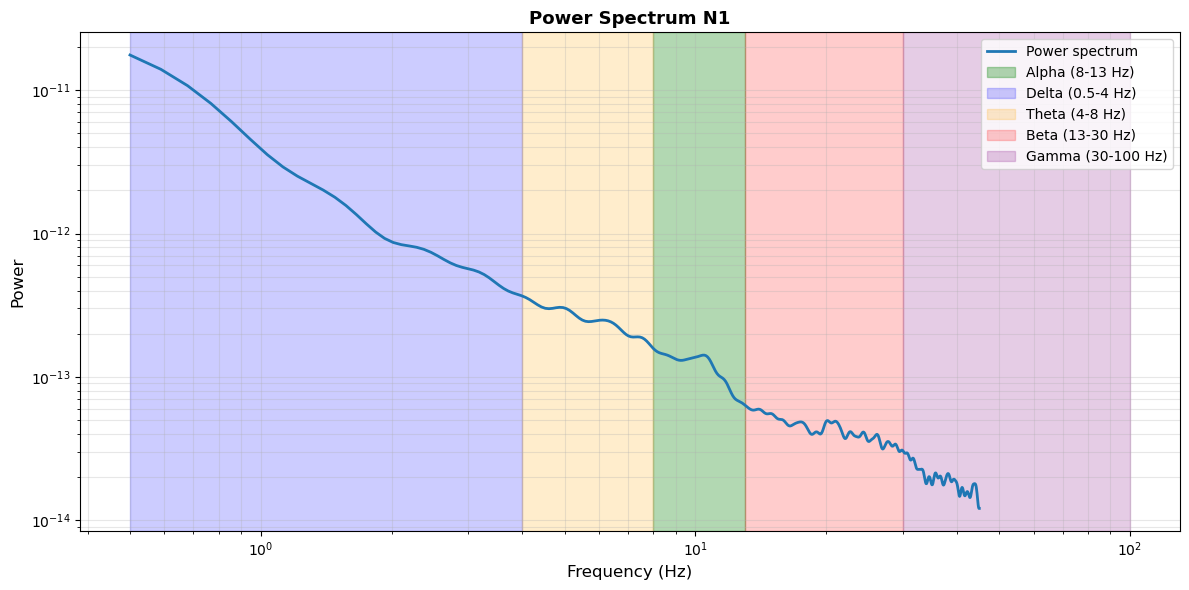

In [14]:
plt.figure(figsize=(12, 6))
plt.loglog(freqs, S_ii, linewidth=2, label='Power spectrum')

# Barre verticali per alpha band (8-13 Hz)
plt.axvspan(8, 13, alpha=0.3, color='green', label='Alpha (8-13 Hz)')

# Opzionale: aggiungi anche altre bande
plt.axvspan(0.5, 4, alpha=0.2, color='blue', label='Delta (0.5-4 Hz)')
plt.axvspan(4, 8, alpha=0.2, color='orange', label='Theta (4-8 Hz)')
plt.axvspan(13, 30, alpha=0.2, color='red', label='Beta (13-30 Hz)')
plt.axvspan(30, 100, alpha=0.2, color='purple', label='Gamma (30-100 Hz)')

plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('Power Spectrum N1', fontsize=13, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.savefig('power_spectrum_with_bands.png')
plt.show()

## Select a chunk of each of the 4 sleep phases and compare the 4 power spectrum

In [15]:
selected_timeseries = {}
freqs = np.linspace(0.3, 45, 1000)  # Frequencies from 0.3 to 45 Hz

C_freqs_dict = {}
S_ii_dict = {}

for stage in ['W', 'N1', 'N2', 'N3', 'R']:

    timeseries, start, end, info = extract_sleep_stage_segment(
        sleep_data, sleep_tag, stage, segment_number=0, segment_length=-1, skip_first_epoch=True, fs=fs
        )
    selected_timeseries[stage] = timeseries

    C_freq = np.zeros((timeseries.shape[0], timeseries.shape[0], len(freqs)), dtype=complex)
    S_ii = []
    
    for i, f in enumerate(tqdm.tqdm(freqs, desc=f"Computing FDC for {stage}")):
        cif = fdc.correlation_freq(
            timeseries,
            time_step=1/fs,
            frequency=f, # in hertz
            n_chunks=50,
            corr_type="covariance"
        )
        C_freq[:, :, i] = cif
        S_ii.append(np.mean(np.diag(cif)))

    C_freqs_dict[stage] = C_freq
    S_ii_dict[stage] = S_ii

    

Stage 'W' - Segment 1/22:
  Full segment epochs: 28
  Extracted: epochs 2-28 (27 epochs)
  First epoch skipped: Yes ✓
  Start index: 80640
  End index: 184320
  Number of samples: 103680
  Duration: 810.00 seconds = 13.50 minutes
  Shape of extracted time series: (83, 103680)


Computing FDC for W: 100%|██████████████████| 1000/1000 [02:59<00:00,  5.56it/s]


           Falling back to including first epoch.
Stage 'N1' - Segment 1/27:
  Full segment epochs: 1
  Extracted: epochs 1-1 (1 epochs)
  First epoch skipped: No (fallback - not enough epochs)
  Start index: 184320
  End index: 188160
  Number of samples: 3840
  Duration: 30.00 seconds = 0.50 minutes
  Shape of extracted time series: (83, 3840)


Computing FDC for N1: 100%|█████████████████| 1000/1000 [00:26<00:00, 37.56it/s]


Stage 'N2' - Segment 1/32:
  Full segment epochs: 17
  Extracted: epochs 2-17 (16 epochs)
  First epoch skipped: Yes ✓
  Start index: 291840
  End index: 353280
  Number of samples: 61440
  Duration: 480.00 seconds = 8.00 minutes
  Shape of extracted time series: (83, 61440)


Computing FDC for N2: 100%|█████████████████| 1000/1000 [02:10<00:00,  7.65it/s]


           Falling back to including first epoch.
Stage 'N3' - Segment 1/16:
  Full segment epochs: 1
  Extracted: epochs 1-1 (1 epochs)
  First epoch skipped: No (fallback - not enough epochs)
  Start index: 353280
  End index: 357120
  Number of samples: 3840
  Duration: 30.00 seconds = 0.50 minutes
  Shape of extracted time series: (83, 3840)


Computing FDC for N3: 100%|█████████████████| 1000/1000 [00:33<00:00, 29.73it/s]


Stage 'R' - Segment 1/3:
  Full segment epochs: 22
  Extracted: epochs 2-22 (21 epochs)
  First epoch skipped: Yes ✓
  Start index: 1240320
  End index: 1320960
  Number of samples: 80640
  Duration: 630.00 seconds = 10.50 minutes
  Shape of extracted time series: (83, 80640)


Computing FDC for R:  86%|████████████████▎  | 858/1000 [02:43<00:27,  5.25it/s]


KeyboardInterrupt: 

### baseline 

In [16]:
from fdc import reshuffling
C_freqs_shuff = {}
S_ii_shuff = {}

for stage in ['W', 'N1', 'N2', 'N3', 'R']:
    reshuffled_ts = reshuffling(selected_timeseries[stage])
    C_freq = np.zeros((reshuffled_ts.shape[0], reshuffled_ts.shape[0], len(freqs)), dtype=complex)
    S_ii = []
    
    for i, f in enumerate(tqdm.tqdm(freqs, desc=f"Computing FDC for {stage}")):
        cif = fdc.correlation_freq(
            reshuffled_ts,
            time_step=1/fs,
            frequency=f, # in hertz
            n_chunks=50,
            corr_type="covariance"
        )
        C_freq[:, :, i] = cif
        S_ii.append(np.mean(np.diag(cif)))

    C_freqs_shuff[stage] = C_freq
    S_ii_shuff[stage] = S_ii

Computing FDC for R: 100%|██████████████████| 1000/1000 [02:11<00:00,  7.59it/s]


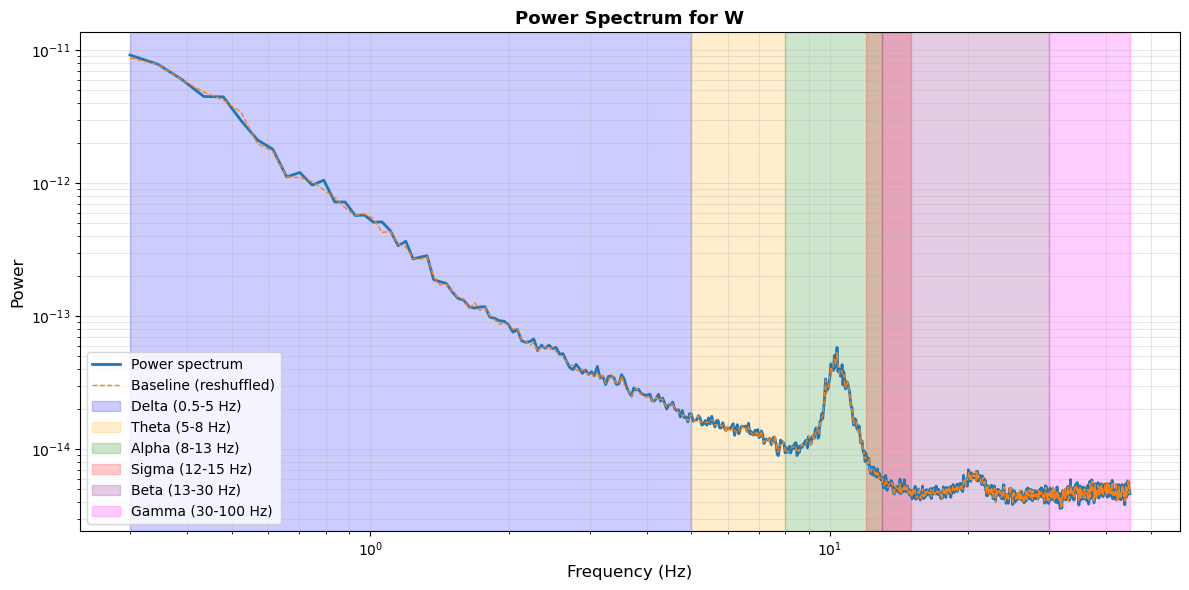

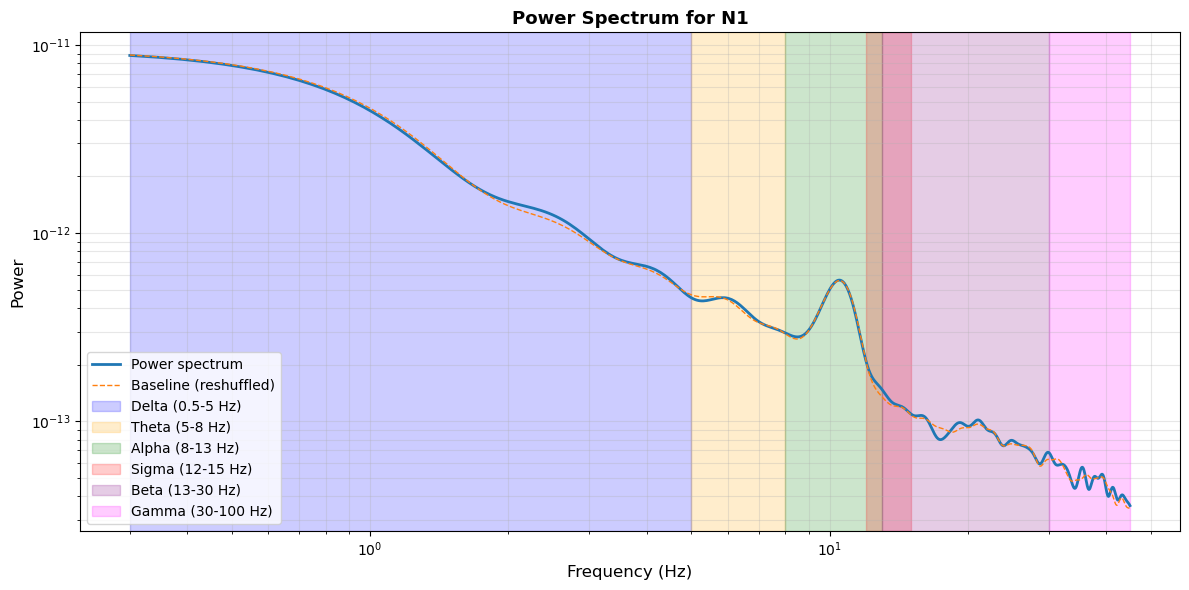

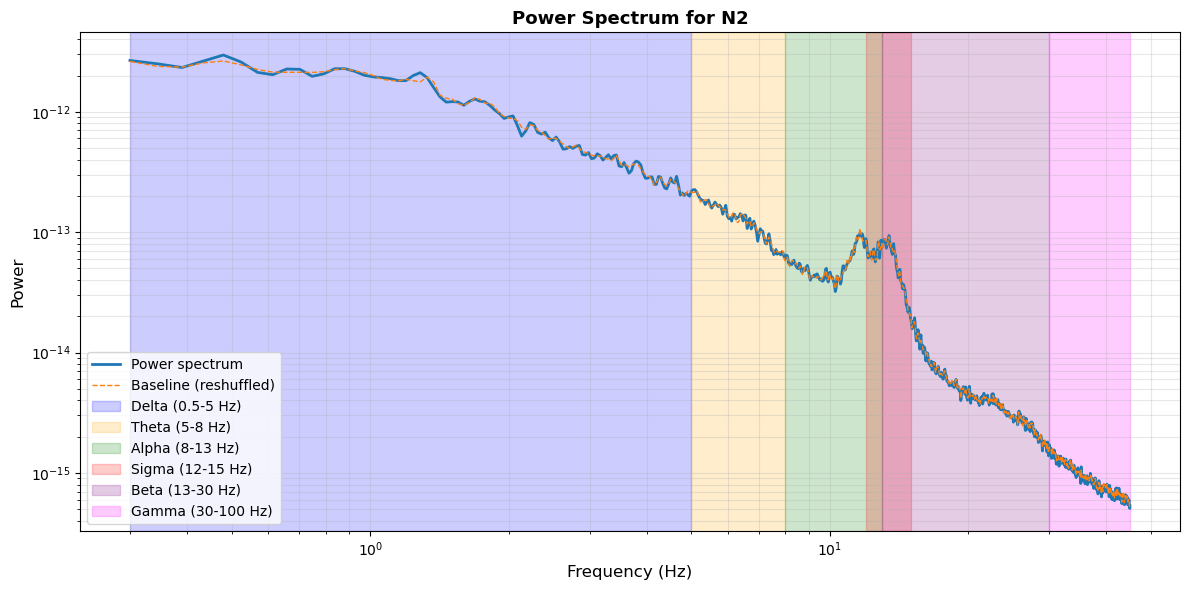

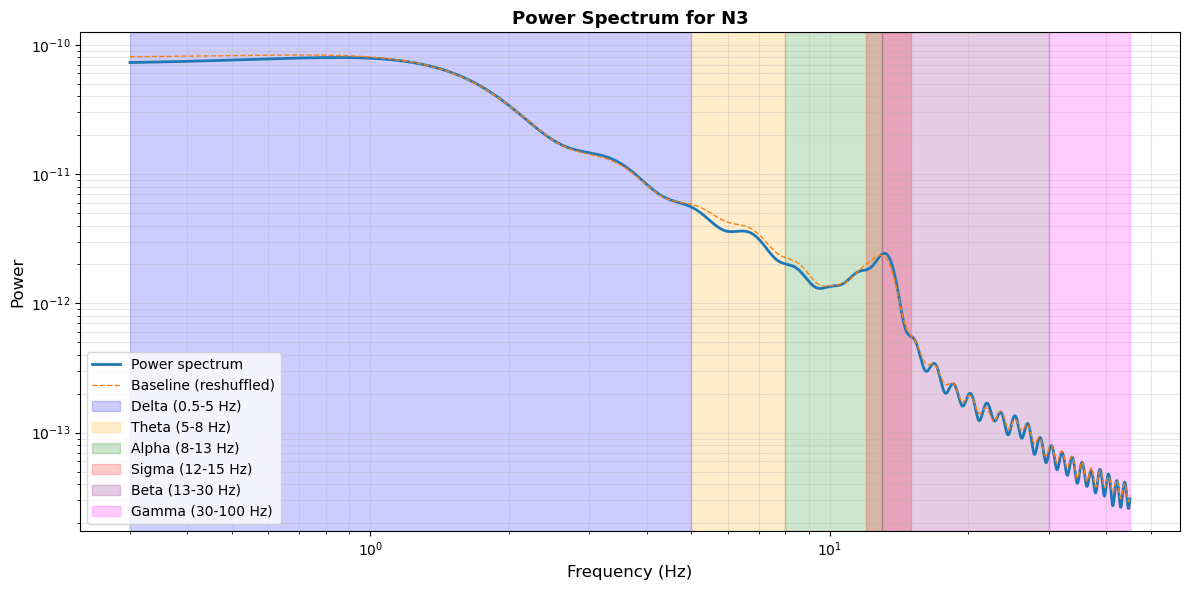

In [17]:
for stage in S_ii_dict.keys():
    plt.figure(figsize=(12, 6))
    plt.loglog(freqs, S_ii_dict[stage], linewidth=2, label='Power spectrum')
    plt.loglog(freqs, S_ii_shuff[stage], linewidth=1, linestyle='--', label='Baseline (reshuffled)')

    # Barre verticali per alpha band (8-13 Hz)
   

    # Opzionale: aggiungi anche altre bande
    plt.axvspan(0.3, 5, alpha=0.2, color='blue', label='Delta (0.5-5 Hz)')
    plt.axvspan(5, 8, alpha=0.2, color='orange', label='Theta (5-8 Hz)')
    plt.axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
    plt.axvspan(12, 15, alpha=0.2, color='red', label='Sigma (12-15 Hz)')
    plt.axvspan(13, 30, alpha=0.2, color='purple', label='Beta (13-30 Hz)')
    plt.axvspan(30, 45, alpha=0.2, color='magenta', label='Gamma (30-100 Hz)')

    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Power', fontsize=12)
    plt.title(f'Power Spectrum for {stage}', fontsize=13, fontweight='bold')
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3, which='both')
    plt.tight_layout()
    plt.savefig(f'power_spectrum_with_bands_{stage}.png')
    plt.show()

# N3 segment 1 (26 mins)

In [36]:
selected_timeseries = {}
freqs = np.linspace(0.3, 45, 1000)  # Frequencies from 0.3 to 45 Hz

C_freqs_dict = {}
S_ii_dict = {}

for stage in ['N3']:

    timeseries, start, end, info = extract_sleep_stage_segment(
        sleep_data, sleep_tag, stage, segment_number=1, segment_length=-1, skip_first_epoch=True, fs=fs
        )
    selected_timeseries[stage] = timeseries

Stage 'N3' - Segment 2/16:
  Full segment epochs: 53
  Extracted: epochs 2-53 (52 epochs)
  First epoch skipped: Yes ✓
  Start index: 414720
  End index: 614400
  Number of samples: 199680
  Duration: 1560.00 seconds = 26.00 minutes
  Shape of extracted time series: (83, 199680)


Computing FDC for N3: 100%|█████████████████| 1000/1000 [04:48<00:00,  3.47it/s]


In [38]:
freqs = np.linspace(0.3, 45, 1000)
samples_per_epoch = fs * 30

S_ii_dict = { 'N3': {} }
C_freqs_dict = { 'N3': {} }

skip_epochs_list = [0, 1, 2, 3, 4]

for skip_k in skip_epochs_list:

    print(f"\nComputing S_ii for N3 skipping {skip_k} extra epoch(s)")

    # ✅ Just CUT the already-extracted signal
    if skip_k > 0:
        cut_samples = skip_k * samples_per_epoch
        if cut_samples >= timeseries.shape[1]:
            print("Too much skipping, no data left.")
            continue
        ts_cut = timeseries[:, cut_samples:]
    else:
        ts_cut = timeseries

    C_freq = np.zeros(
        (ts_cut.shape[0], ts_cut.shape[0], len(freqs)),
        dtype=complex
    )
    S_ii = []

    for i, f in enumerate(tqdm.tqdm(freqs, desc=f"N3 | skip {skip_k}")):
        cif = fdc.correlation_freq(
            ts_cut,
            time_step=1/fs,
            frequency=f,
            n_chunks=50,
            corr_type="covariance"
        )
        C_freq[:, :, i] = cif
        S_ii.append(np.mean(np.diag(cif)))

    C_freqs_dict['N3'][skip_k] = C_freq
    S_ii_dict['N3'][skip_k] = S_ii



Computing S_ii for N3 skipping 0 extra epoch(s)


N3 | skip 0: 100%|██████████████████████████| 1000/1000 [04:46<00:00,  3.49it/s]



Computing S_ii for N3 skipping 1 extra epoch(s)


N3 | skip 1: 100%|██████████████████████████| 1000/1000 [04:42<00:00,  3.55it/s]



Computing S_ii for N3 skipping 2 extra epoch(s)


N3 | skip 2: 100%|██████████████████████████| 1000/1000 [04:36<00:00,  3.61it/s]



Computing S_ii for N3 skipping 3 extra epoch(s)


N3 | skip 3: 100%|██████████████████████████| 1000/1000 [04:34<00:00,  3.65it/s]



Computing S_ii for N3 skipping 4 extra epoch(s)


N3 | skip 4: 100%|██████████████████████████| 1000/1000 [04:39<00:00,  3.58it/s]


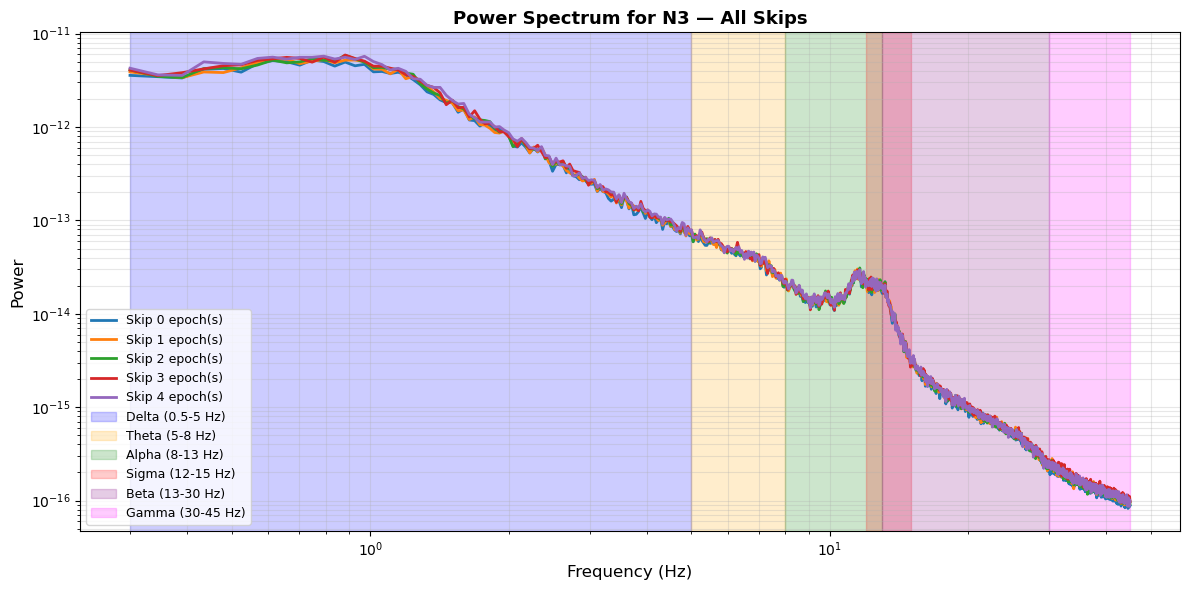

In [39]:
for stage in S_ii_dict.keys():

    plt.figure(figsize=(12, 6))

    # ✅ Plot all skip versions together
    for skip_k, S_ii in S_ii_dict[stage].items():
        plt.loglog(freqs, S_ii, linewidth=2, label=f'Skip {skip_k} epoch(s)')

    # ✅ Frequency bands (same as your original)
    plt.axvspan(0.3, 5, alpha=0.2, color='blue', label='Delta (0.5-5 Hz)')
    plt.axvspan(5, 8, alpha=0.2, color='orange', label='Theta (5-8 Hz)')
    plt.axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
    plt.axvspan(12, 15, alpha=0.2, color='red', label='Sigma (12-15 Hz)')
    plt.axvspan(13, 30, alpha=0.2, color='purple', label='Beta (13-30 Hz)')
    plt.axvspan(30, 45, alpha=0.2, color='magenta', label='Gamma (30-45 Hz)')

    # ✅ Labels and styling
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Power', fontsize=12)
    plt.title(f'Power Spectrum for {stage} — All Skips', fontsize=13, fontweight='bold')
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, alpha=0.3, which='both')
    plt.tight_layout()

    # ✅ Save
    plt.savefig(f'power_spectrum_with_bands_{stage}_all_skips.png')
    plt.show()


# N3 segment 5 (7 minutes)

In [40]:
selected_timeseries = {}
freqs = np.linspace(0.3, 45, 1000)  # Frequencies from 0.3 to 45 Hz

C_freqs_dict = {}
S_ii_dict = {}

for stage in ['N3']:

    timeseries, start, end, info = extract_sleep_stage_segment(
        sleep_data, sleep_tag, stage, segment_number=5, segment_length=-1, skip_first_epoch=False, fs=fs
        )
    selected_timeseries[stage] = timeseries
    

Stage 'N3' - Segment 6/16:
  Full segment epochs: 14
  Extracted: epochs 1-14 (14 epochs)
  Start index: 894720
  End index: 948480
  Number of samples: 53760
  Duration: 420.00 seconds = 7.00 minutes
  Shape of extracted time series: (83, 53760)


In [41]:
freqs = np.linspace(0.3, 45, 1000)
samples_per_epoch = fs * 30

S_ii_dict = { 'N3': {} }
C_freqs_dict = { 'N3': {} }

# ✅ Define (skip_first, skip_last) pairs
skip_pairs = [
    (0, 0),   # keep everything
    (1, 0),   # skip 1 first
    (2, 0),   # skip 2 first
    (1, 1),   # skip 1 first + 1 last
    (2, 2),   # skip 2 first + 2 last
]

for skip_first, skip_last in skip_pairs:

    print(f"\nComputing S_ii for N3 | skip first = {skip_first}, skip last = {skip_last}")

    # ✅ Convert epochs to samples
    cut_first = skip_first * samples_per_epoch
    cut_last  = skip_last  * samples_per_epoch

    # ✅ Safety check
    if cut_first + cut_last >= timeseries.shape[1]:
        print("Too much trimming, no data left — skipping.")
        continue

    # ✅ Symmetric trimming
    if skip_last > 0:
        ts_cut = timeseries[:, cut_first:-cut_last]
    else:
        ts_cut = timeseries[:, cut_first:]

    label = f"first{skip_first}_last{skip_last}"

    # ✅ Allocate
    C_freq = np.zeros(
        (ts_cut.shape[0], ts_cut.shape[0], len(freqs)),
        dtype=complex
    )
    S_ii = []

    # ✅ Frequency loop
    for i, f in enumerate(tqdm.tqdm(freqs, desc=f"N3 | {label}")):
        cif = fdc.correlation_freq(
            ts_cut,
            time_step=1/fs,
            frequency=f,
            n_chunks=50,
            corr_type="covariance"
        )
        C_freq[:, :, i] = cif
        S_ii.append(np.mean(np.diag(cif)))

    # ✅ Store using descriptive key
    C_freqs_dict['N3'][label] = C_freq
    S_ii_dict['N3'][label] = S_ii



Computing S_ii for N3 | skip first = 0, skip last = 0


N3 | first0_last0: 100%|████████████████████| 1000/1000 [01:31<00:00, 10.97it/s]



Computing S_ii for N3 | skip first = 1, skip last = 0


N3 | first1_last0: 100%|████████████████████| 1000/1000 [01:25<00:00, 11.70it/s]



Computing S_ii for N3 | skip first = 2, skip last = 0


N3 | first2_last0: 100%|████████████████████| 1000/1000 [01:20<00:00, 12.36it/s]



Computing S_ii for N3 | skip first = 1, skip last = 1


N3 | first1_last1: 100%|████████████████████| 1000/1000 [01:21<00:00, 12.28it/s]



Computing S_ii for N3 | skip first = 2, skip last = 2


N3 | first2_last2: 100%|████████████████████| 1000/1000 [01:09<00:00, 14.37it/s]


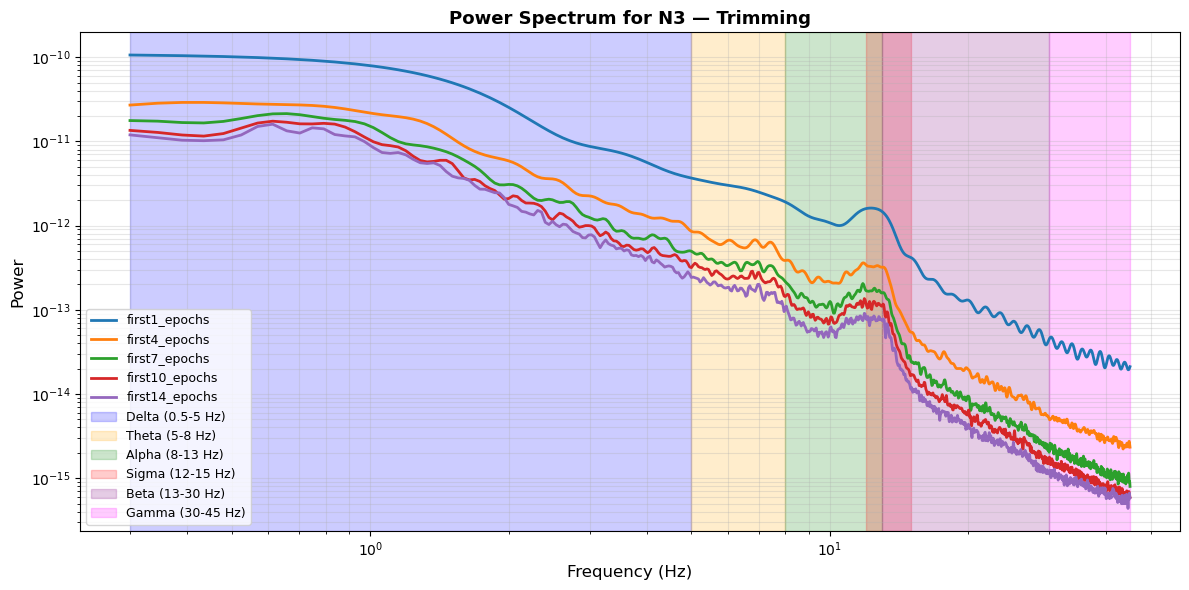

In [46]:
for stage in S_ii_dict.keys():

    plt.figure(figsize=(12, 6))

    for label, S_ii in S_ii_dict[stage].items():
        plt.loglog(freqs, S_ii, linewidth=2, label=label)

    # ✅ Frequency bands (same as your original)
    plt.axvspan(0.3, 5, alpha=0.2, color='blue', label='Delta (0.5-5 Hz)')
    plt.axvspan(5, 8, alpha=0.2, color='orange', label='Theta (5-8 Hz)')
    plt.axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
    plt.axvspan(12, 15, alpha=0.2, color='red', label='Sigma (12-15 Hz)')
    plt.axvspan(13, 30, alpha=0.2, color='purple', label='Beta (13-30 Hz)')
    plt.axvspan(30, 45, alpha=0.2, color='magenta', label='Gamma (30-45 Hz)')

    # ✅ Labels and styling
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Power', fontsize=12)
    plt.title(f'Power Spectrum for {stage} — Trimming end', fontsize=13, fontweight='bold')
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, alpha=0.3, which='both')
    plt.tight_layout()
    plt.savefig(f'power_spectrum_trimmed_{stage}.png')
    plt.show()


In [44]:
samples_per_epoch = fs * 30  # 30 s per epoch
intervals = [1, 4, 7, 10, 14]  # epochs to include progressively


In [45]:
S_ii_dict = {'N3': {}}
C_freqs_dict = {'N3': {}}

freqs = np.linspace(0.3, 45, 1000)

for n_epochs in intervals:

    # Compute number of samples for this chunk
    n_samples = n_epochs * samples_per_epoch

    # Safety check
    if n_samples > timeseries.shape[1]:
        print(f"Skipping {n_epochs} epochs — not enough data")
        continue

    ts_chunk = timeseries[:, :n_samples]  # slice from beginning
    label = f"first{n_epochs}_epochs"

    # Allocate
    C_freq = np.zeros((ts_chunk.shape[0], ts_chunk.shape[0], len(freqs)), dtype=complex)
    S_ii = []

    # Frequency loop
    for i, f in enumerate(tqdm.tqdm(freqs, desc=f"N3 | {label}")):
        cif = fdc.correlation_freq(
            ts_chunk,
            time_step=1/fs,
            frequency=f,
            n_chunks=50,
            corr_type="covariance"
        )
        C_freq[:, :, i] = cif
        S_ii.append(np.mean(np.diag(cif)))

    # Store
    C_freqs_dict['N3'][label] = C_freq
    S_ii_dict['N3'][label] = S_ii


N3 | first1_epochs: 100%|███████████████████| 1000/1000 [00:21<00:00, 45.58it/s]
N3 | first4_epochs: 100%|███████████████████| 1000/1000 [00:37<00:00, 26.71it/s]
N3 | first7_epochs: 100%|███████████████████| 1000/1000 [00:54<00:00, 18.37it/s]
N3 | first10_epochs: 100%|██████████████████| 1000/1000 [01:10<00:00, 14.25it/s]
N3 | first14_epochs: 100%|██████████████████| 1000/1000 [01:30<00:00, 10.99it/s]


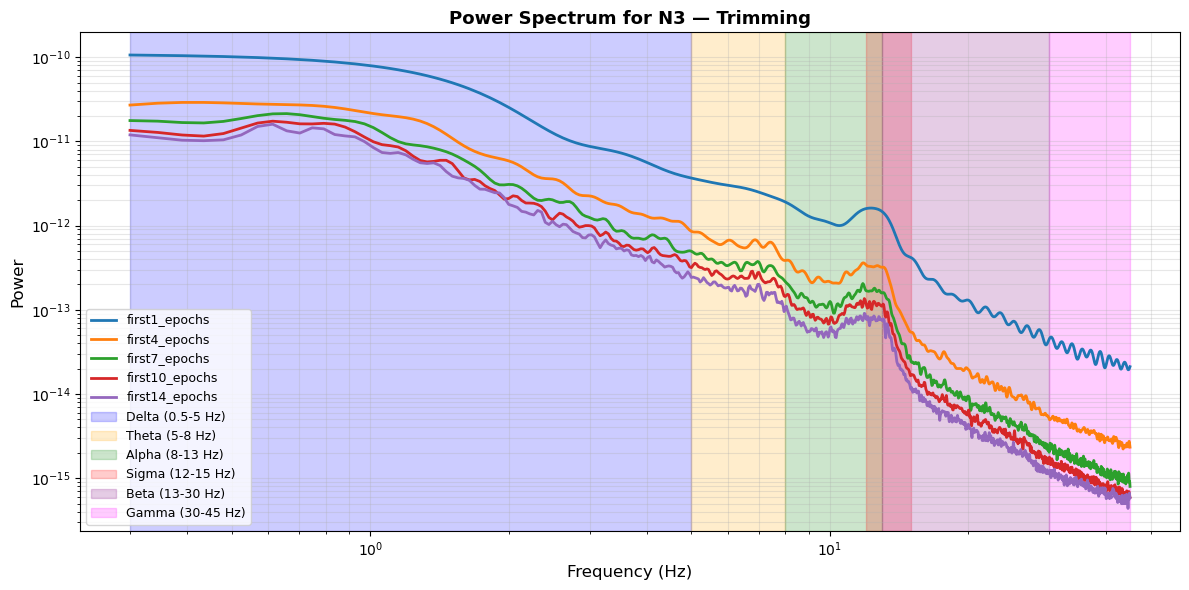

In [53]:
for stage in S_ii_dict.keys():

    plt.figure(figsize=(12, 6))

    for label, S_ii in S_ii_dict[stage].items():
        plt.loglog(freqs, S_ii, linewidth=2, label=label)


    # ✅ Frequency bands (same as your original)
    plt.axvspan(0.3, 5, alpha=0.2, color='blue', label='Delta (0.5-5 Hz)')
    plt.axvspan(5, 8, alpha=0.2, color='orange', label='Theta (5-8 Hz)')
    plt.axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
    plt.axvspan(12, 15, alpha=0.2, color='red', label='Sigma (12-15 Hz)')
    plt.axvspan(13, 30, alpha=0.2, color='purple', label='Beta (13-30 Hz)')
    plt.axvspan(30, 45, alpha=0.2, color='magenta', label='Gamma (30-45 Hz)')

    # ✅ Labels and styling
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Power', fontsize=12)
    plt.title(f'Power Spectrum for {stage} — Trimming', fontsize=13, fontweight='bold')
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, alpha=0.3, which='both')
    plt.tight_layout()
    plt.savefig(f'power_spectrum_progressive_{stage}.png')
    plt.show()


In [48]:
samples_per_epoch = fs * 30
total_epochs = 14  # 7 minutes / 30s intervals

exclude_first_list = [0, 3, 6, 13]  # epochs to exclude from start

S_ii_dict_end = {'N3': {}}
C_freqs_dict_end = {'N3': {}}

freqs = np.linspace(0.3, 45, 1000)

for exclude_first in exclude_first_list:

    start_sample = exclude_first * samples_per_epoch
    ts_chunk = timeseries[:, start_sample:]  # take all the way to the end

    if ts_chunk.shape[1] == 0:
        print(f"No data left after excluding first {exclude_first} epochs — skipping")
        continue

    label = f"exclude_first{exclude_first}_to_end"

    # Allocate
    C_freq = np.zeros((ts_chunk.shape[0], ts_chunk.shape[0], len(freqs)), dtype=complex)
    S_ii = []

    for i, f in enumerate(tqdm.tqdm(freqs, desc=f"N3 | {label}")):
        cif = fdc.correlation_freq(
            ts_chunk,
            time_step=1/fs,
            frequency=f,
            n_chunks=50,
            corr_type="covariance"
        )
        C_freq[:, :, i] = cif
        S_ii.append(np.mean(np.diag(cif)))

    # Store
    C_freqs_dict_end['N3'][label] = C_freq
    S_ii_dict_end['N3'][label] = S_ii


N3 | exclude_first0_to_end: 100%|███████████| 1000/1000 [01:31<00:00, 10.89it/s]
N3 | exclude_first3_to_end: 100%|███████████| 1000/1000 [01:16<00:00, 13.04it/s]
N3 | exclude_first6_to_end: 100%|███████████| 1000/1000 [01:00<00:00, 16.64it/s]
N3 | exclude_first13_to_end: 100%|██████████| 1000/1000 [00:28<00:00, 34.93it/s]


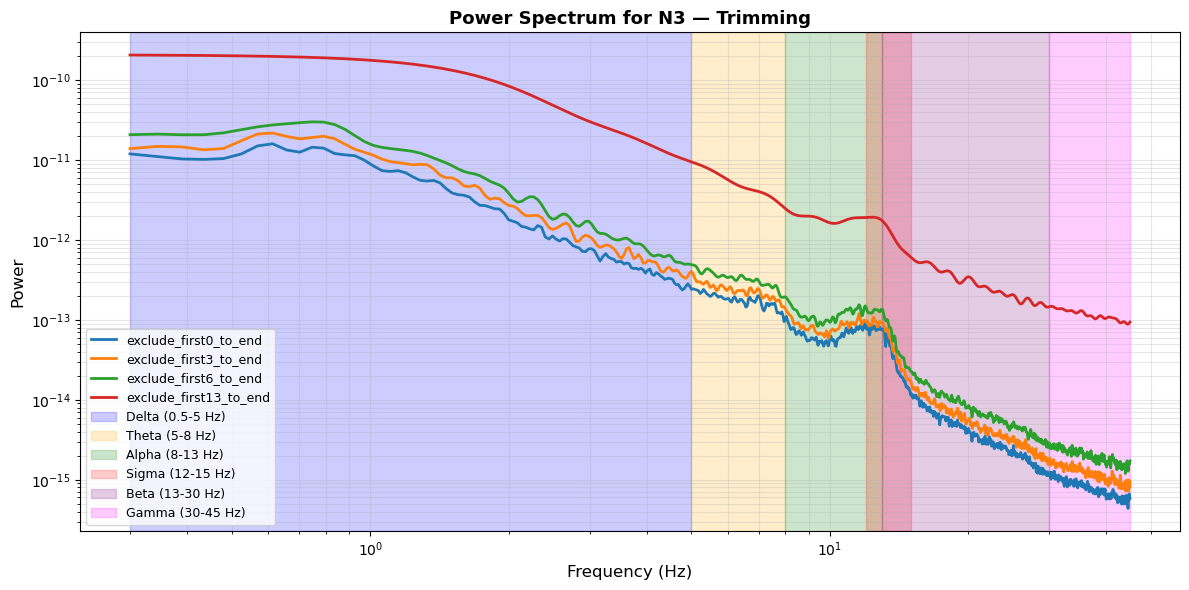

In [49]:
for stage in S_ii_dict_end.keys():
    plt.figure(figsize=(12, 6))

    for label, S_ii in S_ii_dict_end[stage].items():
        plt.loglog(freqs, S_ii, linewidth=2, label=label)

    # ✅ Frequency bands (same as your original)
    plt.axvspan(0.3, 5, alpha=0.2, color='blue', label='Delta (0.5-5 Hz)')
    plt.axvspan(5, 8, alpha=0.2, color='orange', label='Theta (5-8 Hz)')
    plt.axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
    plt.axvspan(12, 15, alpha=0.2, color='red', label='Sigma (12-15 Hz)')
    plt.axvspan(13, 30, alpha=0.2, color='purple', label='Beta (13-30 Hz)')
    plt.axvspan(30, 45, alpha=0.2, color='magenta', label='Gamma (30-45 Hz)')

    # ✅ Labels and styling
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Power', fontsize=12)
    plt.title(f'Power Spectrum for {stage} — Trimming', fontsize=13, fontweight='bold')
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, alpha=0.3, which='both')
    plt.tight_layout()
    plt.savefig(f'power_spectrum_from_end_{stage}.png')
    plt.show()



In [50]:
samples_per_epoch = fs * 30
epoch_indices = [0, 2, 3, 13]  # first, 3rd, 4th, last

S_ii_dict_single = {'N3': {}}
C_freqs_dict_single = {'N3': {}}

freqs = np.linspace(0.3, 45, 1000)

for idx in epoch_indices:

    start_sample = idx * samples_per_epoch
    end_sample = start_sample + samples_per_epoch

    ts_epoch = timeseries[:, start_sample:end_sample]

    if ts_epoch.shape[1] == 0:
        print(f"Epoch {idx} has no data — skipping")
        continue

    label = f"epoch{idx+1}"  # +1 for human-readable indexing

    # Allocate
    C_freq = np.zeros((ts_epoch.shape[0], ts_epoch.shape[0], len(freqs)), dtype=complex)
    S_ii = []

    for i, f in enumerate(tqdm.tqdm(freqs, desc=f"N3 | {label}")):
        cif = fdc.correlation_freq(
            ts_epoch,
            time_step=1/fs,
            frequency=f,
            n_chunks=50,
            corr_type="covariance"
        )
        C_freq[:, :, i] = cif
        S_ii.append(np.mean(np.diag(cif)))

    # Store
    C_freqs_dict_single['N3'][label] = C_freq
    S_ii_dict_single['N3'][label] = S_ii


N3 | epoch1: 100%|████████████████████████| 1000/1000 [1:22:26<00:00,  4.95s/it]
N3 | epoch3: 100%|██████████████████████████| 1000/1000 [00:23<00:00, 42.07it/s]
N3 | epoch4: 100%|██████████████████████████| 1000/1000 [00:36<00:00, 27.57it/s]
N3 | epoch14: 100%|█████████████████████████| 1000/1000 [00:37<00:00, 26.95it/s]


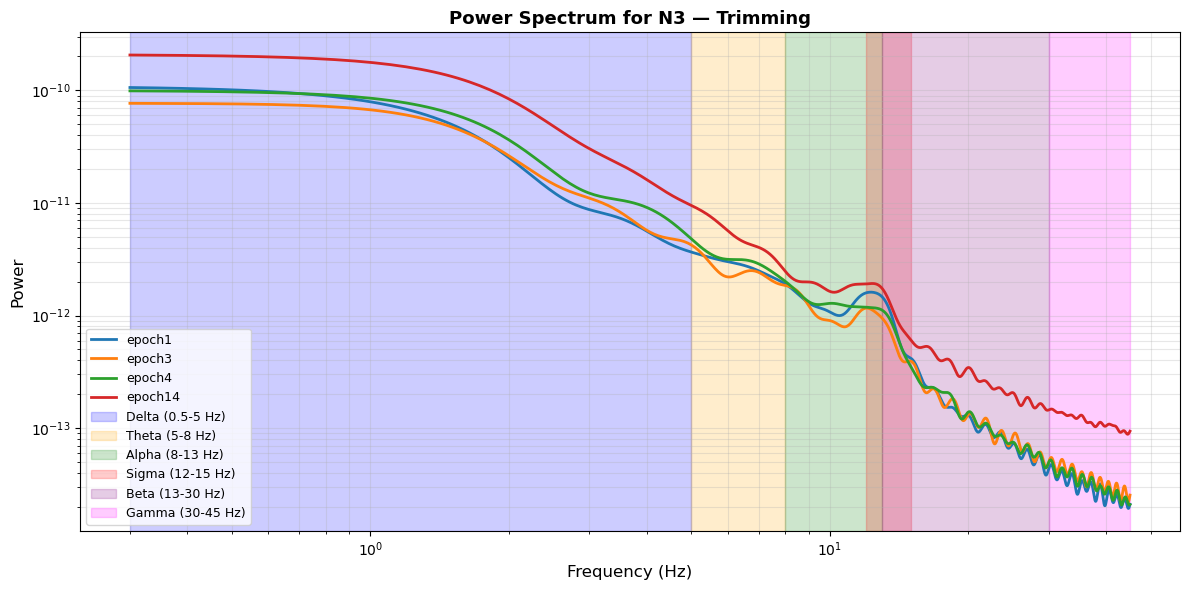

In [52]:
for stage in S_ii_dict_single.keys():
    plt.figure(figsize=(12, 6))

    for label, S_ii in S_ii_dict_single[stage].items():
        plt.loglog(freqs, S_ii, linewidth=2, label=label)

    # ✅ Frequency bands (same as your original)
    plt.axvspan(0.3, 5, alpha=0.2, color='blue', label='Delta (0.5-5 Hz)')
    plt.axvspan(5, 8, alpha=0.2, color='orange', label='Theta (5-8 Hz)')
    plt.axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
    plt.axvspan(12, 15, alpha=0.2, color='red', label='Sigma (12-15 Hz)')
    plt.axvspan(13, 30, alpha=0.2, color='purple', label='Beta (13-30 Hz)')
    plt.axvspan(30, 45, alpha=0.2, color='magenta', label='Gamma (30-45 Hz)')

    # ✅ Labels and styling
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Power', fontsize=12)
    plt.title(f'Power Spectrum for {stage} — Trimming', fontsize=13, fontweight='bold')
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, alpha=0.3, which='both')
    plt.tight_layout()
    plt.savefig(f'power_spectrum_single_epochs_{stage}.png')
    plt.show()


# Extract 50 epochs for each stage

In [54]:
def extract_n_epochs(sleep_data, sleep_tag, stage_label, n_epochs=50, fs=128):
    """
    Extract n_epochs consecutive epochs of a given stage,
    concatenating multiple segments if needed.
    """
    samples_per_epoch = fs * 30
    stages = sleep_tag['L'].values
    expanded_labels = np.repeat(stages, samples_per_epoch)
    n_samples_total = min(len(expanded_labels), sleep_data.shape[1])
    expanded_labels = expanded_labels[:n_samples_total]

    # Get all indices for the stage
    stage_indices = np.where(expanded_labels == stage_label)[0]
    if len(stage_indices) == 0:
        print(f"No samples found for stage {stage_label}")
        return None

    # Split indices into consecutive segments
    breaks = np.where(np.diff(stage_indices) > 1)[0] + 1
    segments = np.split(stage_indices, breaks) if len(breaks) > 0 else [stage_indices]

    # Concatenate segments until we reach n_epochs
    collected_samples = []
    collected_epochs = 0
    for seg in segments:
        seg_epochs = len(seg) // samples_per_epoch
        if seg_epochs == 0:
            continue
        # Take full segment or part of it
        needed_epochs = n_epochs - collected_epochs
        take_epochs = min(seg_epochs, needed_epochs)
        take_samples = seg[:take_epochs * samples_per_epoch]
        collected_samples.append(take_samples)
        collected_epochs += take_epochs
        if collected_epochs >= n_epochs:
            break

    # Concatenate all samples
    collected_samples = np.concatenate(collected_samples)
    segment_data = sleep_data[:, collected_samples]

    return segment_data


In [55]:
stages = ['W', 'N1', 'N2', 'N3', 'R', 'L']
selected_timeseries = {}
fs = 128
n_epochs_to_extract = 50

for stage in stages:
    ts = extract_n_epochs(sleep_data, sleep_tag, stage, n_epochs=n_epochs_to_extract, fs=fs)
    if ts is not None:
        selected_timeseries[stage] = ts
        print(f"{stage}: extracted shape {ts.shape}")


W: extracted shape (83, 192000)
N1: extracted shape (83, 192000)
N2: extracted shape (83, 192000)
N3: extracted shape (83, 192000)
R: extracted shape (83, 192000)
L: extracted shape (83, 122880)


In [56]:
freqs = np.linspace(0.3, 45, 1000)
C_freqs_dict = {}
S_ii_dict = {}

for stage, ts in selected_timeseries.items():
    C_freq = np.zeros((ts.shape[0], ts.shape[0], len(freqs)), dtype=complex)
    S_ii = []

    for i, f in enumerate(tqdm.tqdm(freqs, desc=f"Computing FDC for {stage}")):
        cif = fdc.correlation_freq(
            ts,
            time_step=1/fs,
            frequency=f,
            n_chunks=50,
            corr_type="covariance"
        )
        C_freq[:, :, i] = cif
        S_ii.append(np.mean(np.diag(cif)))

    C_freqs_dict[stage] = C_freq
    S_ii_dict[stage] = S_ii


Computing FDC for L: 100%|██████████████████| 1000/1000 [03:33<00:00,  4.69it/s]


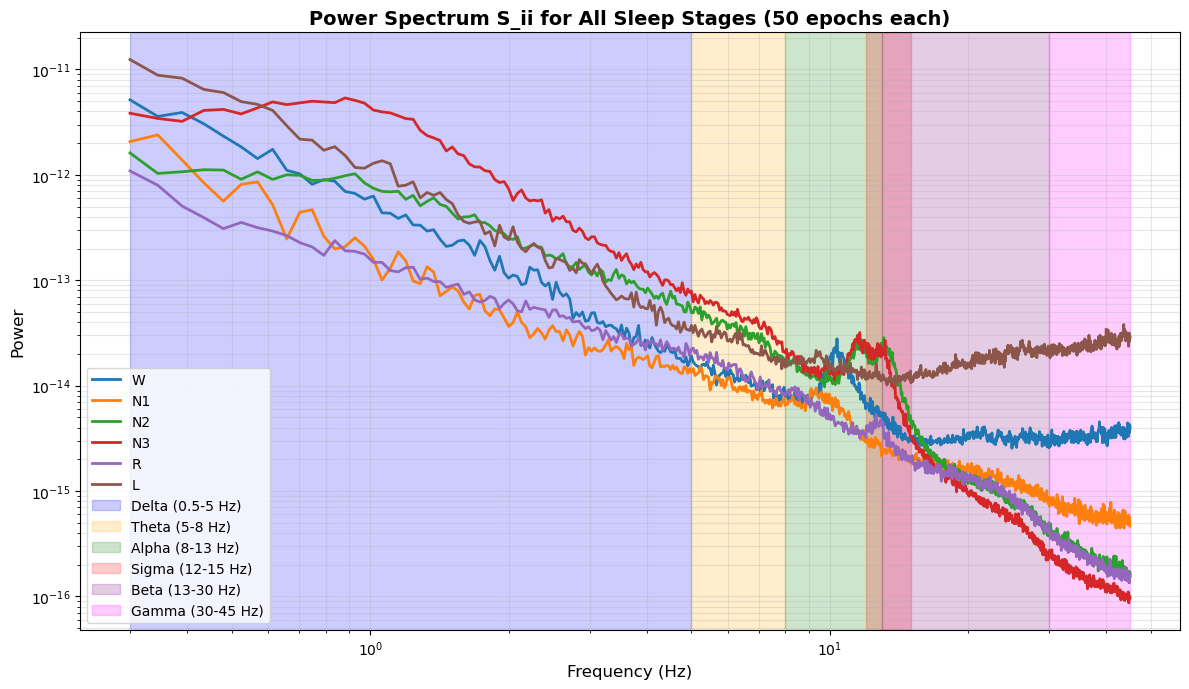

In [61]:
plt.figure(figsize=(12, 7))

for stage, S_ii in S_ii_dict.items():
    plt.loglog(freqs, S_ii, linewidth=2, label=stage)

# ✅ Frequency bands (same as your original)
plt.axvspan(0.3, 5, alpha=0.2, color='blue', label='Delta (0.5-5 Hz)')
plt.axvspan(5, 8, alpha=0.2, color='orange', label='Theta (5-8 Hz)')
plt.axvspan(8, 13, alpha=0.2, color='green', label='Alpha (8-13 Hz)')
plt.axvspan(12, 15, alpha=0.2, color='red', label='Sigma (12-15 Hz)')
plt.axvspan(13, 30, alpha=0.2, color='purple', label='Beta (13-30 Hz)')
plt.axvspan(30, 45, alpha=0.2, color='magenta', label='Gamma (30-45 Hz)')

# ✅ Labels and styling
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title(f'Power Spectrum for {stage} — Trimming', fontsize=13, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()

# ✅ Labels & title
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('Power Spectrum S_ii for All Sleep Stages (50 epochs each)', fontsize=14, fontweight='bold')

# ✅ Legend & grid
plt.legend(fontsize=10)
plt.grid(True, which='both', alpha=0.3)

# ✅ Save & show
plt.tight_layout()
plt.savefig("power_spectrum_all_stages.png")
plt.show()


In [1]:
S_ii_dict

NameError: name 'S_ii_dict' is not defined